<a href="https://colab.research.google.com/github/edcalderin/LLM_Tech/blob/master/Improve_tabular_data_predictions_with_LLM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Improve tabular data predictions with LLM

Dataset: https://www.kaggle.com/datasets/pritsheta/heart-attack

## Download dataset

In [63]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("pritsheta/heart-attack")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/heart-attack


In [ ]:
!ls /root/.cache/kagglehub/datasets/pritsheta/heart-attack/versions/1

'Heart Attack Data Set.csv'


## Read data

In [64]:
import pandas as pd
path: str = "/root/.cache/kagglehub/datasets/pritsheta/heart-attack/versions/1/"
csv_name: str = "Heart Attack Data Set.csv"
data: pd.DataFrame = pd.read_csv(path + csv_name)
print(data.shape)
data.head()

(303, 14)


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [ ]:
data["ca"].value_counts()

,count
ca,
0,175
1,65
2,38
3,20
4,5


In [ ]:
data[["age", "cp", "trestbps",  "chol", "thalach", "oldpeak"]].describe()

,age,cp,trestbps,chol,thalach,oldpeak
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.366337,0.966997,131.623762,246.264026,149.646865,1.039604
std,9.082101,1.032052,17.538143,51.830751,22.905161,1.161075
min,29.000000,0.000000,94.000000,126.000000,71.000000,0.000000
25%,47.500000,0.000000,120.000000,211.000000,133.500000,0.000000
50%,55.000000,1.000000,130.000000,240.000000,153.000000,0.800000
75%,61.000000,2.000000,140.000000,274.500000,166.000000,1.600000
max,77.000000,3.000000,200.000000,564.000000,202.000000,6.200000


In [ ]:
data.isna().sum().sum()

np.int64(0)

## OHE

In [65]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split

# Train-test split
X = data.drop("target", axis=1)
y = data["target"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42)

# Category columns for OHE
cat_cols = ["sex", "cp", "fbs", "restecg", "exang", "slope", "ca", "thal"]
col_trans = ColumnTransformer(
    [("ohe", OneHotEncoder(sparse_output=False, handle_unknown="ignore"),
      cat_cols)
    ],
    remainder="passthrough")

X_train_ohe = col_trans.fit_transform(X_train)
X_test_ohe = col_trans.transform(X_test)

In [66]:
X_train_ohe = pd.DataFrame(X_train_ohe, columns=col_trans.get_feature_names_out())
X_test_ohe = pd.DataFrame(X_test_ohe, columns=col_trans.get_feature_names_out())

## Fit models

In [182]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

# Define a function for plotting ROC curves with distinct colors
def plot_roc_curves(y_true, pred_dict):
    plt.figure(figsize=(8, 6))

    # Define a color palette with distinct colors
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']
    line_styles = ['-', '-', '-', '-', '--', '--']
    line_widths = [2.5, 2.5, 2.5, 2.5, 2.5, 2.5]

    # Plot ROC curve for each model
    for (name, y_pred), color, ls, lw in zip(pred_dict.items(), colors, line_styles, line_widths):
        fpr, tpr, _ = roc_curve(y_true, y_pred)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, color=color, linestyle=ls, lw=lw,
                 label=f'{name} (AUC = {roc_auc:.3f})')

    # Add the diagonal reference line
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=1.5, alpha=0.7)

    # Customize the plot
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title('ROC Curves Comparison', fontsize=14, fontweight='bold')
    plt.legend(loc='lower right', fontsize=10, frameon=True, facecolor='white', edgecolor='gray')
    plt.grid(True, alpha=0.3)

    # Add background color
    plt.gca().set_facecolor('#f8f9fa')

    plt.tight_layout()
    plt.show()

def ml_models(suffix:str="")->dict:
    lr = LogisticRegression(
        penalty=None, solver='saga', random_state=42, n_jobs=-1)
    lasso = LogisticRegression(
        penalty='l1', solver='saga', random_state=42, n_jobs=-1)
    ridge = LogisticRegression(
        penalty='l2', solver='saga', random_state=42, n_jobs=-1)
    rf = RandomForestClassifier(
        n_estimators=300,
        max_depth=5,
        min_samples_leaf=50,
        max_features=0.3,
        random_state=42,
        n_jobs=-1)

    return {
        f'LR{suffix}': lr,
        f'LASSO{suffix}': lasso,
        f'RIDGE{suffix}': ridge,
        f'RF{suffix}': rf
    }

def get_predictions_all_models(X_train, X_test, y_train, y_test, suffix:str="")->dict:
    models: dict = ml_models(suffix)
    pred_dict: dict = {}
    for name, model in models.items():
        model.fit(X_train, y_train)
        preds = model.predict_proba(X_test)[:, 1]
        _auc: float = roc_auc_score(y_test, preds)
        pred_dict[name] = preds
    return pred_dict

Model AUC Scores:
--------------------
LR: 0.825
LASSO: 0.824
RIDGE: 0.825
RF: 0.887


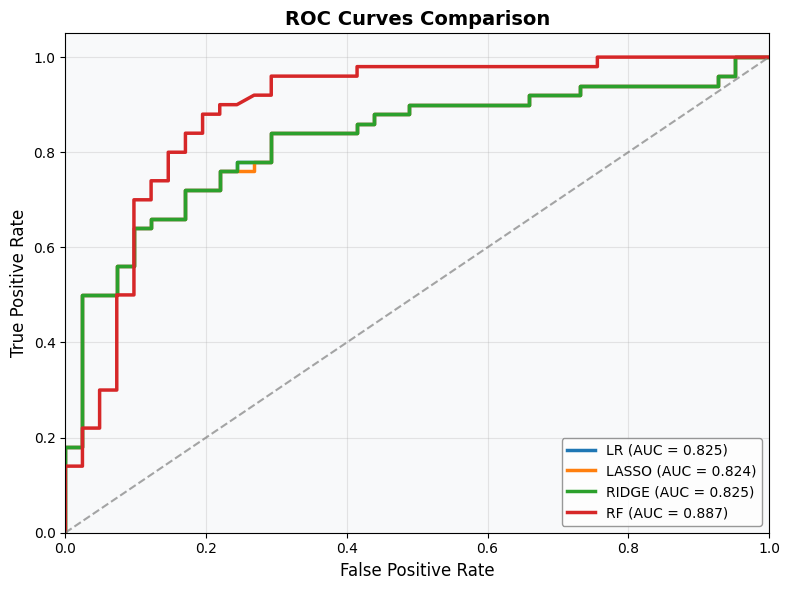

In [ ]:
import warnings

warnings.filterwarnings("ignore")

# Use your existing code with the new plotting function
models: dict = ml_models()
pred_dict: dict = {}

# Print AUC scores for each model
pred_dict = get_predictions_all_models(X_train_ohe, X_test_ohe, y_train, y_test)

# Plot all ROC curves with distinct colors
plot_roc_curves(y_test, pred_dict)

## GPT

### Pre-processing tabular data

In [69]:
data['restecg'].value_counts()

,count
restecg,
1,152
0,147
2,4


In [155]:
import numpy as np

df_gpt = data.copy()
df_gpt['sex'] = np.where(df_gpt['sex'] == 1, 'Male', 'Female')
df_gpt['cp'] = np.select(
    [df_gpt['cp'] == 1, df_gpt['cp'] == 2, df_gpt['cp'] == 3],
    ['Typical angina', 'Atypical angina', 'Non-anginal pain'],
    'Asymptomatic')
df_gpt['fbs'] = np.where(
    df_gpt['fbs'] == 1,
    'Fasting blood sugar > 120 mg/dl',
    'Fasting blood sugar <= 120 mg/dl')
df_gpt['restecg'] = np.select(
    [df_gpt['restecg'] == 0, df_gpt['restecg'] == 1],
    ['Normal',
     'Having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV)'],
    "Showing probable or definite left ventricular hypertrophy by Estes' criteria")
df_gpt['exang'] = np.where(
    df_gpt['exang'] == 1,
    'Exercise induced angina',
    'Without exercise induced angina')
df_gpt['slope'] = np.select(
    [df_gpt['slope'] == 0, df_gpt['slope'] == 1],
    ['The slope of the peak exercise ST segment is downsloping',
     'The slope of the peak exercise ST segment is flat'],
    'The slope of the peak exercise ST segment is upsloping')
df_gpt['thal'] = np.select(
    [df_gpt['thal'] == 1, df_gpt['thal'] == 2],
    ['thal is fixed defect', 'thal is normal'],
    'thal is reversable defect')

# test df to dict
application_list = X_test.to_dict(orient='records')
len(application_list)

91

In [76]:
from pydantic import BaseModel, Field
from langchain_core.output_parsers import PydanticOutputParser

class HeartAttackResponse(BaseModel):
    decision: str = Field(description="Either less or more chance of heart attack")
    reasoning: str = Field(descriotion="Provide a 100 words explanation of why you made this decision")

parser = PydanticOutputParser(pydantic_object=HeartAttackResponse)

In [71]:
system_prompt: str = """
You are a medical expert / underwriter in a global insurance company. Your job
is to evaluate the chance of having heart attack.
Please encode your response as json in the following format:

{format_instructions}
"""

human_prompt: str = """
---- BEGIN OF THE DATA ----
What is the age of the applicant?: {age}
What is the sex of the applicant?: {sex}
What is the chest pain type of the applicant?: {cp}
What is the resting blood pressure (in mm Hg) of the applicant?: {trestbps}
What is the cholestoral in mg/dl fetched via BMI sensor of the applicant?: {chol}
What is the fasting blood sugar level of the applicant?: {fbs}
What is the resting electrocardiographic results of the applicant?: {restecg}
What is the maximum heart rate achieved of the applicant?: {thalach}
What is the exercise induced angina of the applicant?: {exang}
What is the ST depression induced by exercise relative to rest of the applicant?: {oldpeak}
What is the slope of the peak exercise ST segment of the applicant?: {slope}
What is the number of major vessels of the applicant?: {ca}
What is the thal of the applicant?: {thal}
---- END OF THE DATA ----
"""

In [22]:
!pip install python-dotenv

In [77]:
from dotenv import load_dotenv
from openai import OpenAI
import json

load_dotenv()

client = OpenAI()

def predict_openai(data: dict)->dict:
    response = client.chat.completions.create(
        model="gpt-4o",
        messages=[
            {"role": "system", "content": system_prompt.format(parser.get_format_instructions())},
            {"role": "user", "content": human_prompt.format(**data)}
        ],
        temperature=0
    )
    response = response.choices[0].message.content
    response = response.replace("```", "").replace("json\n","")
    return json.loads(response)

In [86]:
import concurrent.futures
from tqdm import tqdm

def predict_with_concurrency(df: pd.DataFrame, max_workers: int=5):
    """Process the dataframe with concurrent API calls"""
    # Convert each row to a dictionary
    data_list = [dict(row) for _, row in df.iterrows()]
    results = []

    # Use ThreadPoolExecutor for concurrent API calls
    with concurrent.futures.ThreadPoolExecutor(max_workers=max_workers) as executor:
        # Create a function that includes the API key
        fn = lambda x: predict_openai(x)

        # Submit all tasks and track with tqdm for progress
        futures = list(tqdm(
            executor.map(fn, data_list),
            total=len(data_list),
            desc="Processing API calls"
        ))

        results = futures

    return results

In [87]:
%%time

max_concurrent = 10

# Run concurrent predictions
responses = predict_with_concurrency(df_gpt, max_workers=max_concurrent)

# Convert to DataFrame
responses_df = pd.DataFrame(responses)
print(responses_df.shape)

Processing API calls: 100%|██████████| 303/303 [01:45<00:00,  2.87it/s]

(303, 2)
CPU times: user 3.28 s, sys: 155 ms, total: 3.44 s
Wall time: 1min 45s


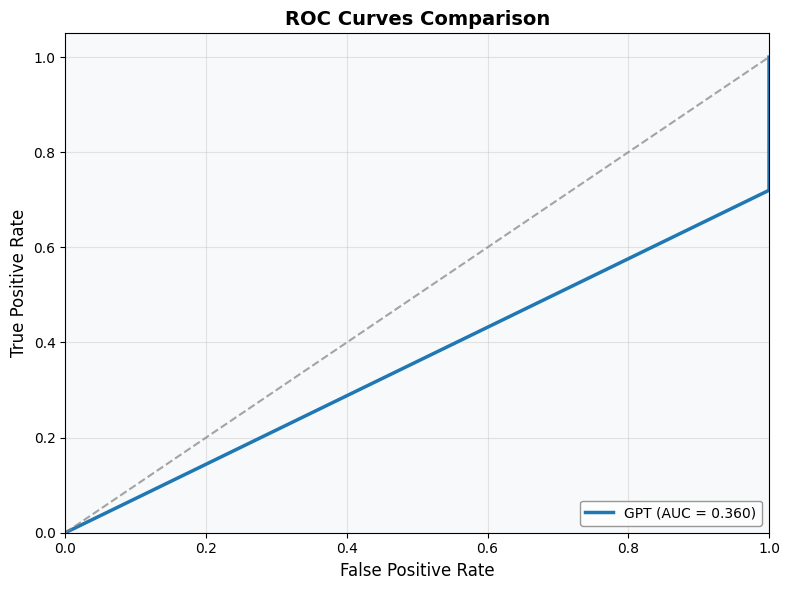

In [102]:
responses_df_copy = responses_df.copy()
responses_df_copy["decision"] = np.where(responses_df_copy["decision"].str.startswith("more"), 1, 0)

# Extract validation predictions from GPT responses
y_pred_gpt = responses_df_copy.iloc[y_test.index]

plot_roc_curves(y_test, {"GPT": y_pred_gpt["decision"]})

### Embeddings

In [156]:
from openai import OpenAI

load_dotenv()

client = OpenAI()

df_gpt["combined"] = df_gpt.drop("target", axis=1)\
                                .apply(lambda x: " ".join(x.astype(str)), axis=1)

def get_embeddings(text: str, model: str)->list:
    embedding_response = client.embeddings.create(input=text, model=model)
    return embedding_response.data[0].embedding

In [157]:
df_gpt["embeddings"] = df_gpt.apply(
    lambda x: get_embeddings(x["combined"], "text-embedding-ada-002"), axis=1)

df_gpt = df_gpt.join(df_gpt["embeddings"].apply(pd.Series))
df_gpt.drop(["combined", "embeddings"], axis=1, inplace=True)
df_gpt.columns = df_gpt.columns[:14].tolist() + [f"Embedding_{col}" for col in df_gpt.columns[14:].tolist()]

In [162]:
data = pd.concat([data, df_gpt.filter(like="Embedding")], axis=1)

In [163]:
df_gpt.shape

(303, 1550)

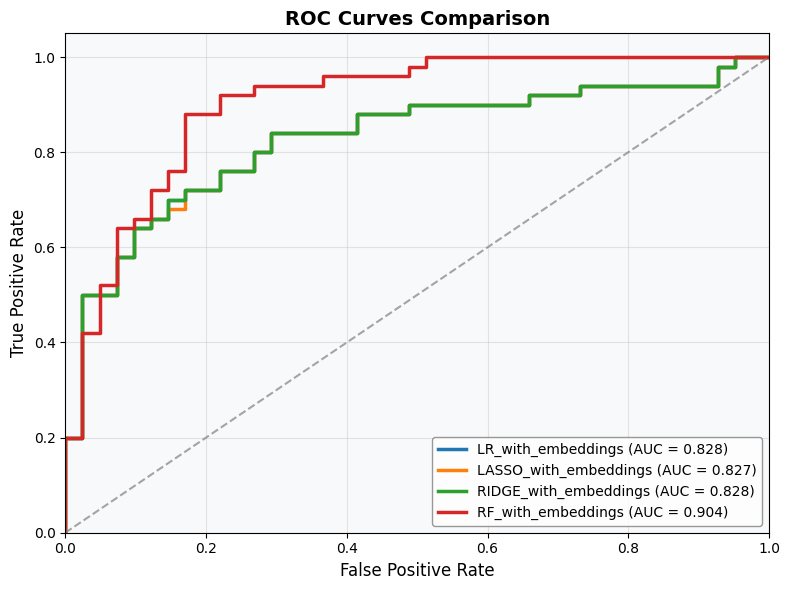

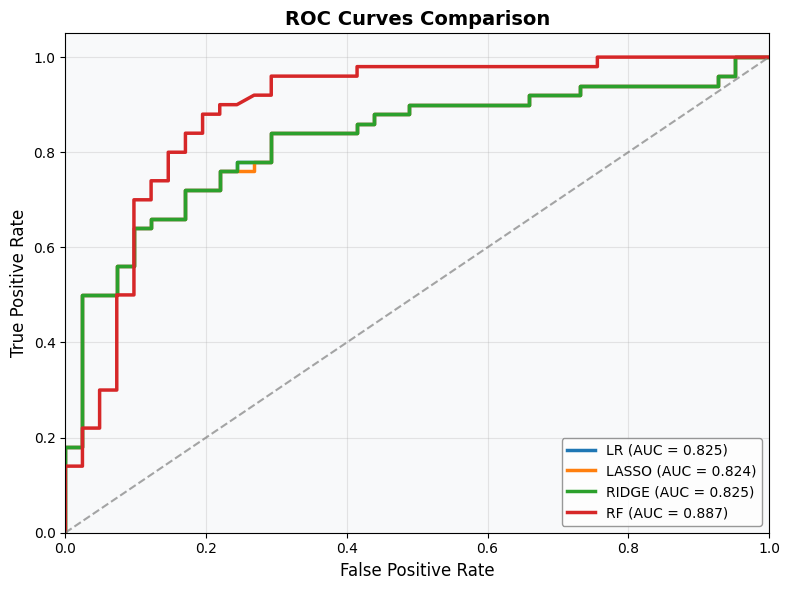

In [183]:
import warnings
warnings.filterwarnings("ignore")

# Train-test split
X = data.drop("target", axis=1)
y = data["target"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42)
pred_dict = get_predictions_all_models(X_train, X_test, y_train, y_test, "_with_embeddings")
plot_roc_curves(y_test, pred_dict)

pred_dict = get_predictions_all_models(X_train_ohe, X_test_ohe, y_train, y_test)
plot_roc_curves(y_test, pred_dict)

Results using embeddings do not contribute significantly to the overall model performance. However, Random Forest with embeddings achieved a remarkably better result compared to the rest of the models.